In [1]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL /competitive-data-science-predict-future-sales/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL /competitive-data-science-predict-future-sales/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL /competitive-data-science-predict-future-sales/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL /competitive-data-science-predict-future-sales/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL /competitive-data-science-predict-future-sales/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                      'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [4]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [5]:
print(f'Train rows: {train.shape[0]}')
print(f'Train columns: {train.shape[1]}')

display(train.head().T)
display(train.describe())

Train rows: 2935849
Train columns: 10


,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [6]:
print(f"Min date from train set: {train['date'].min().date()}")
print(f"Max date from train set: {train['date'].max().date()}")

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


In [7]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
train = train[train['item_id'].isin(test_item_ids)]

In [8]:
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_cnt_day':['sum']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')
# Label
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

display(train_monthly.head(10).T)
display(train_monthly.describe().T)

,0,1,2,3,4,5,6,7,8,9
date_block_num,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
item_id,33.00,482.00,491.00,839.00,1007.00,1010.00,1023.00,1204.00,1224.00,1247.00
item_cnt,1.00,1.00,1.00,1.00,3.00,1.00,2.00,1.00,1.00,1.00
item_cnt_month,2.00,1.00,1.00,1.00,1.00,1.00,1.00,nan,nan,nan


,count,mean,std,min,25%,50%,75%,max
date_block_num,593829.00,20.18,9.14,0.00,13.00,22.00,28.00,33.00
shop_id,593829.00,32.07,16.90,2.00,19.00,31.00,47.00,59.00
item_id,593829.00,10015.02,6181.82,30.00,4418.00,9171.00,15334.00,22167.00
item_cnt,593829.00,2.10,2.31,0.00,1.00,1.00,2.00,20.00
item_cnt_month,482536.00,2.07,2.17,0.00,1.00,1.00,2.00,20.00


In [9]:
monthly_series = train_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',values='item_cnt', fill_value=0).reset_index()
monthly_series.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,2,2,0,2,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0
4,2,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [10]:
first_month = 20
last_month = 33
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['shop_id'], row['item_id']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,31,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,31,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,32,2,2,0,2,0,0,1,0,0,0,0,1,0


In [11]:
data_series = data_series.drop(['item_id', 'shop_id'], axis=1)

In [12]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

In [13]:
print("Train set", train.shape)
print("Validation set", valid.shape)
train.head()

Train set (200327, 12)
Validation set (22259, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
207604,0,0,0,0,0,0,0,0,0,0,0,0
45150,0,0,0,0,0,0,0,0,0,0,0,0
143433,0,0,4,2,1,2,2,1,0,0,0,1
202144,0,0,0,0,0,0,0,0,0,0,0,0
136088,0,0,0,0,0,0,0,1,0,0,1,0


In [14]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (200327, 12, 1)
Validation set reshaped (22259, 12, 1)


In [15]:
serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

epochs = 20
batch = 128
lr = 0.0001

lstm_model = Sequential()
lstm_model.add(L.LSTM(10, input_shape=(serie_size, n_features), return_sequences=True))
lstm_model.add(L.LSTM(6, activation='relu', return_sequences=True))
lstm_model.add(L.LSTM(1, activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(1))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 10)            480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 6)             408       
_________________________________________________________________
lstm_2 (LSTM)                (None, 1)                 32        
_________________________________________________________________
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
______________________________________________________

In [16]:
lstm_history = lstm_model.fit(X_train, Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

Epoch 1/20
1566/1566 - 22s - loss: 1.5067 - val_loss: 1.3122
Epoch 2/20
1566/1566 - 18s - loss: 1.3280 - val_loss: 1.2557
Epoch 3/20
1566/1566 - 18s - loss: 1.2744 - val_loss: 1.2236
Epoch 4/20
1566/1566 - 18s - loss: 1.2339 - val_loss: 1.1950
Epoch 5/20
1566/1566 - 18s - loss: 1.2026 - val_loss: 1.1723
Epoch 6/20
1566/1566 - 18s - loss: 1.1754 - val_loss: 1.1573
Epoch 7/20
1566/1566 - 18s - loss: 1.1700 - val_loss: 1.1529
Epoch 8/20
1566/1566 - 18s - loss: 1.1677 - val_loss: 1.1511
Epoch 9/20
1566/1566 - 18s - loss: 1.1664 - val_loss: 1.1484
Epoch 10/20
1566/1566 - 18s - loss: 1.1652 - val_loss: 1.1484
Epoch 11/20
1566/1566 - 18s - loss: 1.1642 - val_loss: 1.1489
Epoch 12/20
1566/1566 - 18s - loss: 1.1637 - val_loss: 1.1464
Epoch 13/20
1566/1566 - 18s - loss: 1.1629 - val_loss: 1.1453
Epoch 14/20
1566/1566 - 18s - loss: 1.1624 - val_loss: 1.1446
Epoch 15/20
1566/1566 - 18s - loss: 1.1616 - val_loss: 1.1444
Epoch 16/20
1566/1566 - 18s - loss: 1.1616 - val_loss: 1.1459
Epoch 17/20
1566/

In [18]:
encoder_decoder = Sequential()
encoder_decoder.add(L.LSTM(serie_size, activation='relu', input_shape=(serie_size, n_features), return_sequences=True))
encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(L.LSTM(1, activation='relu'))
encoder_decoder.add(L.RepeatVector(serie_size))
encoder_decoder.add(L.LSTM(serie_size, activation='relu', return_sequences=True))
encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(L.TimeDistributed(L.Dense(1)))
encoder_decoder.summary()

adam = optimizers.Adam(lr)
encoder_decoder.compile(loss='mse', optimizer=adam)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 12, 12)            672       
_________________________________________________________________
lstm_9 (LSTM)                (None, 12, 6)             456       
_________________________________________________________________
lstm_10 (LSTM)               (None, 1)                 32        
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 12, 1)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 12, 12)            672       
_________________________________________________________________
lstm_12 (LSTM)               (None, 12, 6)             456       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 1)            

In [19]:
encoder_decoder_history = encoder_decoder.fit(X_train, X_train, 
                                              batch_size=batch, 
                                              epochs=epochs, 
                                              verbose=2)

Epoch 1/20
1566/1566 - 34s - loss: 1.6350
Epoch 2/20
1566/1566 - 29s - loss: 1.2388
Epoch 3/20
1566/1566 - 29s - loss: 1.1044
Epoch 4/20
1566/1566 - 29s - loss: 1.0701
Epoch 5/20
1566/1566 - 29s - loss: 1.0494
Epoch 6/20
1566/1566 - 29s - loss: 1.0377
Epoch 7/20
1566/1566 - 29s - loss: 1.0321
Epoch 8/20
1566/1566 - 29s - loss: 1.0235
Epoch 9/20
1566/1566 - 29s - loss: 1.0134
Epoch 10/20
1566/1566 - 29s - loss: 1.0002
Epoch 11/20
1566/1566 - 29s - loss: 0.9849
Epoch 12/20
1566/1566 - 29s - loss: 0.9707
Epoch 13/20
1566/1566 - 29s - loss: 0.9671
Epoch 14/20
1566/1566 - 29s - loss: 0.9761
Epoch 15/20
1566/1566 - 29s - loss: 0.9629
Epoch 16/20
1566/1566 - 29s - loss: 0.9706
Epoch 17/20
1566/1566 - 28s - loss: 0.9445
Epoch 18/20
1566/1566 - 29s - loss: 0.9326
Epoch 19/20
1566/1566 - 29s - loss: 0.9253
Epoch 20/20
1566/1566 - 29s - loss: 0.9327


In [20]:
rpt_vector_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[3].output)
time_dist_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[5].output)
encoder_decoder.layers

In [21]:
rpt_vector_layer_output = rpt_vector_layer.predict(X_train[:1])
print('Repeat vector output shape', rpt_vector_layer_output.shape)
print('Repeat vector output sample')
print(rpt_vector_layer_output[0])

Repeat vector output shape (1, 12, 1)
Repeat vector output sample
[[0.04086111]
 [0.04086111]
 [0.04086111]
 [0.04086111]
 [0.04086111]
 [0.04086111]
 [0.04086111]
 [0.04086111]
 [0.04086111]
 [0.04086111]
 [0.04086111]
 [0.04086111]]


In [22]:
time_dist_layer_output = time_dist_layer.predict(X_train[:1])
print('Time distributed output shape', time_dist_layer_output.shape)
print('Time distributed output sample')
print(time_dist_layer_output[0])

Time distributed output shape (1, 12, 6)
Time distributed output sample
[[0.00000000e+00 0.00000000e+00 2.94537116e-02 0.00000000e+00
  0.00000000e+00 8.18665028e-02]
 [0.00000000e+00 1.97241805e-03 2.10141242e-02 2.69282726e-03
  0.00000000e+00 6.13531172e-02]
 [0.00000000e+00 7.52239721e-03 1.43331224e-02 1.05716754e-02
  0.00000000e+00 4.35485244e-02]
 [0.00000000e+00 1.57864634e-02 9.29334480e-03 2.25895494e-02
  0.00000000e+00 2.95862462e-02]
 [0.00000000e+00 2.64813378e-02 5.65298367e-03 3.71751934e-02
  0.00000000e+00 1.88286118e-02]
 [0.00000000e+00 3.90007496e-02 3.17051704e-03 5.16946651e-02
  0.00000000e+00 1.08537497e-02]
 [0.00000000e+00 5.35230786e-02 1.60688115e-03 6.28760457e-02
  0.00000000e+00 5.41194109e-03]
 [0.00000000e+00 6.85746968e-02 7.15526054e-04 6.78812340e-02
  0.00000000e+00 2.16754153e-03]
 [1.45982262e-02 7.98508003e-02 2.71278812e-04 6.48648813e-02
  0.00000000e+00 6.24831708e-04]
 [4.93545271e-02 7.95824453e-02 8.50855504e-05 5.47706857e-02
  0.0000000

In [23]:
encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[2].output)

In [24]:
train_encoded = encoder.predict(X_train)
validation_encoded = encoder.predict(X_valid)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

Encoded time-series shape (200327, 1)
Encoded time-series sample [0.04086111]


In [25]:
train['encoded'] = train_encoded
train['label'] = Y_train

valid['encoded'] = validation_encoded
valid['label'] = Y_valid

train.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,encoded,label
207604,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0
45150,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0
143433,0,0,4,2,1,2,2,1,0,0,0,1,0.65,1
202144,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0
136088,0,0,0,0,0,0,0,1,0,0,1,0,0.05,1
121675,0,0,0,0,0,1,0,0,0,0,0,0,0.10,0
185281,0,0,0,0,0,0,0,0,0,0,0,0,0.04,1
70087,0,0,0,0,0,0,0,0,3,0,1,3,0.88,0
105249,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0
183257,0,0,0,0,0,3,0,1,0,0,0,1,0.45,0


In [26]:
last_month = serie_size - 1
Y_train_encoded = train['label']
train.drop('label', axis=1, inplace=True)
X_train_encoded = train[[last_month, 'encoded']]

Y_valid_encoded = valid['label']
valid.drop('label', axis=1, inplace=True)
X_valid_encoded = valid[[last_month, 'encoded']]

print("Train set", X_train_encoded.shape)
print("Validation set", X_valid_encoded.shape)

Train set (200327, 2)
Validation set (22259, 2)


In [27]:
X_train_encoded.head()

,11,encoded
207604,0,0.04
45150,0,0.04
143433,1,0.65
202144,0,0.04
136088,0,0.05


In [28]:
mlp_model = Sequential()
mlp_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train_encoded.shape[1]))
mlp_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(1))
mlp_model.summary()

adam = optimizers.Adam(lr)
mlp_model.compile(loss='mse', optimizer=adam)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [29]:
mlp_history = mlp_model.fit(X_train_encoded.values, Y_train_encoded.values, epochs=epochs, batch_size=batch, validation_data=(X_valid_encoded, Y_valid_encoded), verbose=2)

Epoch 1/20
1566/1566 - 2s - loss: 1.3476 - val_loss: 1.2150
Epoch 2/20
1566/1566 - 1s - loss: 1.2412 - val_loss: 1.1982
Epoch 3/20
1566/1566 - 1s - loss: 1.2324 - val_loss: 1.1938
Epoch 4/20
1566/1566 - 1s - loss: 1.2287 - val_loss: 1.1926
Epoch 5/20
1566/1566 - 1s - loss: 1.2263 - val_loss: 1.1912
Epoch 6/20
1566/1566 - 1s - loss: 1.2244 - val_loss: 1.1884
Epoch 7/20
1566/1566 - 1s - loss: 1.2225 - val_loss: 1.1876
Epoch 8/20
1566/1566 - 1s - loss: 1.2210 - val_loss: 1.1873
Epoch 9/20
1566/1566 - 1s - loss: 1.2201 - val_loss: 1.1855
Epoch 10/20
1566/1566 - 1s - loss: 1.2187 - val_loss: 1.1840
Epoch 11/20
1566/1566 - 1s - loss: 1.2176 - val_loss: 1.1844
Epoch 12/20
1566/1566 - 1s - loss: 1.2169 - val_loss: 1.1825
Epoch 13/20
1566/1566 - 1s - loss: 1.2162 - val_loss: 1.1821
Epoch 14/20
1566/1566 - 1s - loss: 1.2153 - val_loss: 1.1816
Epoch 15/20
1566/1566 - 1s - loss: 1.2144 - val_loss: 1.1813
Epoch 16/20
1566/1566 - 1s - loss: 1.2136 - val_loss: 1.1804
Epoch 17/20
1566/1566 - 1s - loss

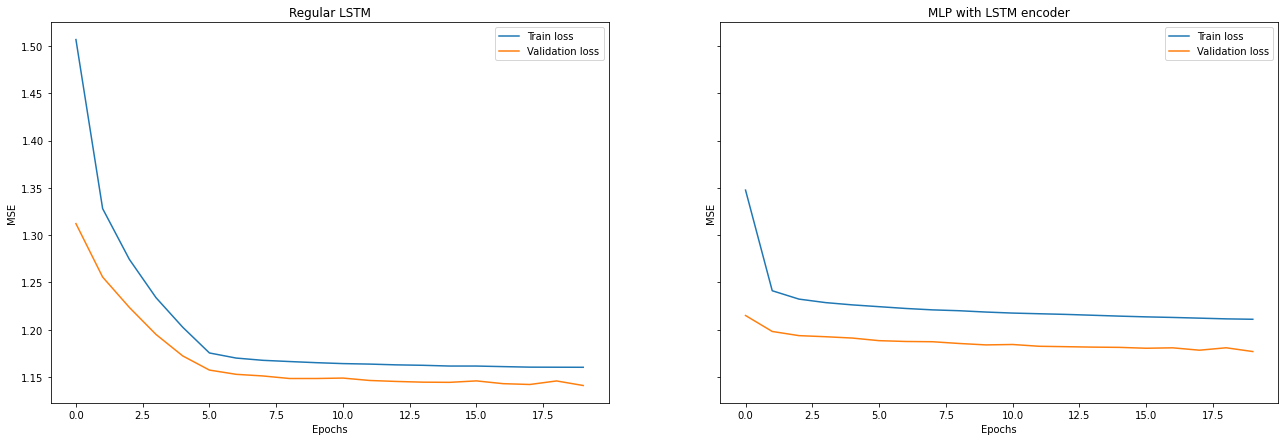

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(22,7))

ax1.plot(lstm_history.history['loss'], label='Train loss')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Regular LSTM')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(mlp_history.history['loss'], label='Train loss')
ax2.plot(mlp_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('MLP with LSTM encoder')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

plt.show()

In [31]:
lstm_train_pred = lstm_model.predict(X_train)
lstm_val_pred = lstm_model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))

Train rmse: 1.0764664296356412
Validation rmse: 1.0681904215881908


In [32]:
mlp_train_pred2 = mlp_model.predict(X_train_encoded.values)
mlp_val_pred2 = mlp_model.predict(X_valid_encoded.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_encoded, mlp_train_pred2)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_encoded, mlp_val_pred2)))

Train rmse: 1.1001068362419109
Validation rmse: 1.0848680365287242


In [33]:
latest_records = monthly_series.drop_duplicates(subset=['shop_id', 'item_id'])
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['ID', 'item_id', 'shop_id'], axis=1, inplace=True)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [34]:
X_test = X_test[[(i + (34 - serie_size)) for i in range(serie_size)]]
X_test.head()

,22,23,24,25,26,27,28,29,30,31,32,33
0,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [35]:
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test_reshaped.shape)

(214200, 12, 1)


In [36]:
lstm_test_pred = lstm_model.predict(X_test_reshaped)

In [37]:
test_encoded = encoder.predict(X_test_reshaped)

In [38]:
X_test['encoded'] = test_encoded
X_test.head()

,22,23,24,25,26,27,28,29,30,31,32,33,encoded
0,1.00,2.00,2.00,0.00,0.00,0.00,1.00,1.00,1.00,3.00,1.00,0.00,0.65
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04
2,0.00,0.00,0.00,0.00,0.00,0.00,3.00,2.00,0.00,1.00,3.00,1.00,1.06
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.04
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04


In [39]:
X_test_encoded = X_test[[33, 'encoded']]
print("Train set", X_test_encoded.shape)
X_test_encoded.head()

Train set (214200, 2)


,33,encoded
0,0.00,0.65
1,0.00,0.04
2,1.00,1.06
3,0.00,0.04
4,0.00,0.04


In [40]:
mlp_test_pred = mlp_model.predict(X_test_encoded)

In [41]:
lstm_prediction = pd.DataFrame(test['ID'], columns=['ID'])
lstm_prediction['item_cnt_month'] = lstm_test_pred.clip(0., 20.)
lstm_prediction.to_csv('lstm_submission.csv', index=False)
lstm_prediction.head(10)

,ID,item_cnt_month
0,0,0.55
1,1,0.49
2,2,0.85
3,3,0.17
4,4,0.49
5,5,0.44
6,6,0.98
7,7,0.17
8,8,1.22
9,9,0.49


In [42]:
mlp_prediction = pd.DataFrame(test['ID'], columns=['ID'])
mlp_prediction['item_cnt_month'] = mlp_test_pred.clip(0., 20.)
mlp_prediction.to_csv('mlp_submission.csv', index=False)
mlp_prediction.head(10)

,ID,item_cnt_month
0,0,0.23
1,1,0.39
2,2,0.71
3,3,0.39
4,4,0.39
5,5,0.58
6,6,0.91
7,7,0.21
8,8,0.72
9,9,0.39
